In [2]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_main'

df = pd.read_csv(froot + ".csv")#, chunksize=100000)

In [3]:
print(df.head())

   seqnames    start      end strand  ensembl_gene_id  score      ctcf  \
0         1  3859709  3859709      +  ENSG00000169598    0.0 -0.010876   
1         1  3859710  3859710      +  ENSG00000169598    0.0 -0.010887   
2         1  3859711  3859711      +  ENSG00000169598    0.0 -0.010902   
3         1  3859712  3859712      +  ENSG00000169598    0.0 -0.010920   
4         1  3859713  3859713      +  ENSG00000169598    0.0 -0.010941   

   h3k36me3   h3k4me1  h3k79me2  ...       sj3       dms      rpts  wgbs  \
0  0.353765 -0.078256 -0.156547  ... -0.057178 -0.307549  0.249626   0.0   
1  0.347003 -0.077117 -0.155891  ... -0.057178 -0.307549  0.249626   0.0   
2  0.340295 -0.075994 -0.155236  ... -0.057178 -0.307549  0.249626   0.0   
3  0.333641 -0.074887 -0.154583  ... -0.057178 -0.307549  0.249626   0.0   
4  0.327043 -0.073795 -0.153930  ... -0.057178 -0.307549  0.249626   0.0   

       A         T         G         C  lambda_alphaj      zeta  
0 -0.625 -0.678443  1.954571 -0.

In [4]:
df['gene_length'] = df.groupby('ensembl_gene_id')['ensembl_gene_id'].transform('count')

In [5]:
filtered_df = df[df['gene_length'] == 2000]

In [6]:
column_names = filtered_df.columns.tolist()
feature_names = column_names[6:-7]
nucleotides = column_names[-7:-3]
print(feature_names)
print(nucleotides)

# process read counts
X_ji = filtered_df.groupby('ensembl_gene_id')['score'].apply(list).tolist() 
print(X_ji)

# process GLM simulated elongation rates
Z_ji = filtered_df.groupby('ensembl_gene_id')['zeta'].apply(list).tolist() 

num_samples = len(X_ji)

['ctcf', 'h3k36me3', 'h3k4me1', 'h3k79me2', 'h3k9me1', 'h3k9me3', 'h4k20me1', 'sj5', 'sj3', 'dms', 'rpts', 'wgbs']
['A', 'T', 'G', 'C']
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.00476439740959, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.00476439740959, 0.0, 0.0, 0.0, 1.00476439740959, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.00476439740959, 0.0, 1.00476439740959, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [7]:
from sklearn.preprocessing import MinMaxScaler

#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   [[sample_1_feature_1], [sample_1_feature_2], [sample_1_feature_3]],
    #   [[sample_2_feature_1], [sample_1_feature_2], [sample_1_feature_3]],  
    # ]

Y_ji = []

for sample_id in filtered_df['ensembl_gene_id'].unique():
    sample_data = [filtered_df[feature_name][filtered_df['ensembl_gene_id'] == sample_id].tolist() for feature_name in feature_names]
    Y_ji.append(sample_data)
    

# normalize features
scaler = MinMaxScaler()
Y_ji = np.array(Y_ji)
# reshape dataset to [num_samples, num_features * feature_length]
Y_ji_reshaped = Y_ji.reshape(Y_ji.shape[0], -1)
normalized_Y_ji_reshaped = scaler.fit_transform(Y_ji_reshaped)
Y_ji = normalized_Y_ji_reshaped.reshape(Y_ji.shape)

In [8]:
C_j = filtered_df.groupby('ensembl_gene_id')['lambda_alphaj'].apply(list).tolist() 

In [9]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, Y_ji, X_ji, C_j, Z_ji):
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.X_ji)

    def __getitem__(self, idx):
        return {
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [10]:
dataset = CustomDataset(Y_ji, X_ji, C_j, Z_ji)

trnset, valset, tstset = td.random_split(dataset, [0.5,0.25,0.25])

trndl = DataLoader(trnset, batch_size=64, shuffle=True)
tstdl = DataLoader(tstset, batch_size=64, shuffle=True)
valdl = DataLoader(valset, batch_size=64, shuffle=True)

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs):
        outputs, _ = self.lstm(inputs)
        averaged_outputs = torch.mean(outputs, dim=1)
        predictions = self.fc(averaged_outputs)
        return predictions

# input size: [50, 12, 2000]
input_size = 2000
hidden_size = 32
output_size = 2000

model = Model(input_size, hidden_size, output_size)
print(model)

Model(
  (lstm): LSTM(2000, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2000, bias=True)
)


In [12]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        loss = X_ji * Z_ji + C_j * torch.exp(-Z_ji)
        # compute mean over batch to normalize due to varying batch sizes
        return loss.mean() 

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    for batch in trndl:
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji']
        X_ji_batch = batch['X_ji']
        C_j_batch = batch['C_j']
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/100], Loss: 0.035245101898908615
Epoch [2/100], Loss: 0.034932684153318405
Epoch [3/100], Loss: 0.03471627086400986
Epoch [4/100], Loss: 0.034506067633628845
Epoch [5/100], Loss: 0.03429589048027992
Epoch [6/100], Loss: 0.034034404903650284
Epoch [7/100], Loss: 0.03375159949064255
Epoch [8/100], Loss: 0.033441636711359024
Epoch [9/100], Loss: 0.033111847937107086
Epoch [10/100], Loss: 0.03276403248310089
Epoch [11/100], Loss: 0.032404620200395584
Epoch [12/100], Loss: 0.032018501311540604
Epoch [13/100], Loss: 0.03160717710852623
Epoch [14/100], Loss: 0.03119307942688465
Epoch [15/100], Loss: 0.030755408108234406
Epoch [16/100], Loss: 0.030314533039927483
Epoch [17/100], Loss: 0.02985738031566143
Epoch [18/100], Loss: 0.029396764934062958
Epoch [19/100], Loss: 0.02893730066716671
Epoch [20/100], Loss: 0.028459573164582253
Epoch [21/100], Loss: 0.027971457690000534
Epoch [22/100], Loss: 0.027473144233226776
Epoch [23/100], Loss: 0.026978526264429092
Epoch [24/100], Loss: 0.0264

In [80]:
from matplotlib import pyplot as plt
epochs = range(1, len(hist[0]) + 1)
plt.plot(epochs, hist[0], label='train_loss')
plt.plot(epochs, hist[1], label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

NameError: name 'hist' is not defined

In [171]:
mae = []
mse = []
for inputs, labels in tstdl:
    #interpret_model(inputs, labels)
    outputs = model(inputs)
    mae.append(torch.mean(torch.abs(outputs - labels), dim=0))
    mse.append(torch.mean((outputs - labels)**2, dim=0))

mean_mae = torch.mean(torch.stack(mae))    
mean_mse = torch.mean(torch.stack(mse))
print("Overall Mean Absolute Error (MAE):", round(mean_mae.item(), 3))
print("Overall Mean Squared Error (MSE):", round(mean_mse.item(), 3))

Overall Mean Absolute Error (MAE): 0.019
Overall Mean Squared Error (MSE): 0.002


In [14]:
model.eval()

inputs = next(iter(tstdl)) 
print("number of samples: " + str(len(inputs)))

with torch.no_grad():
    outputs = model(inputs['Y_ji'])
    
print(outputs)

targets = inputs['Z_ji']

number of samples: 4
tensor([[ 0.0917, -0.1349,  0.2006,  ...,  0.7433,  0.5220, -0.5047],
        [ 1.6685, -0.0244,  1.1443,  ...,  0.5955,  0.6733, -1.1897],
        [ 0.5883, -0.2104,  0.3617,  ...,  1.2032,  0.3166,  0.0228],
        ...,
        [ 0.6924, -0.1645,  0.5236,  ...,  1.3598,  0.4189, -0.1418],
        [ 0.9092, -0.8609,  1.3754,  ...,  0.0269,  0.4513, -0.1632],
        [ 0.5360, -0.5520,  0.7457,  ..., -0.5952,  1.0165, -0.9840]])


In [15]:
print(targets.shape)
print(outputs.shape)
print(targets)

torch.Size([24, 2000])
torch.Size([24, 2000])
tensor([[1.0565, 1.0575, 1.0584,  ..., 0.8553, 0.8566, 0.8580],
        [0.7573, 0.7561, 0.7549,  ..., 0.2873, 0.2874, 0.2875],
        [0.8651, 0.8653, 0.8655,  ..., 1.1066, 1.1063, 1.1060],
        ...,
        [0.9755, 0.9759, 0.9763,  ..., 1.0794, 1.0786, 1.0778],
        [1.1362, 1.1364, 1.1366,  ..., 1.0763, 1.0871, 1.0871],
        [0.7644, 0.7640, 0.7636,  ..., 1.0048, 1.0051, 1.0055]])


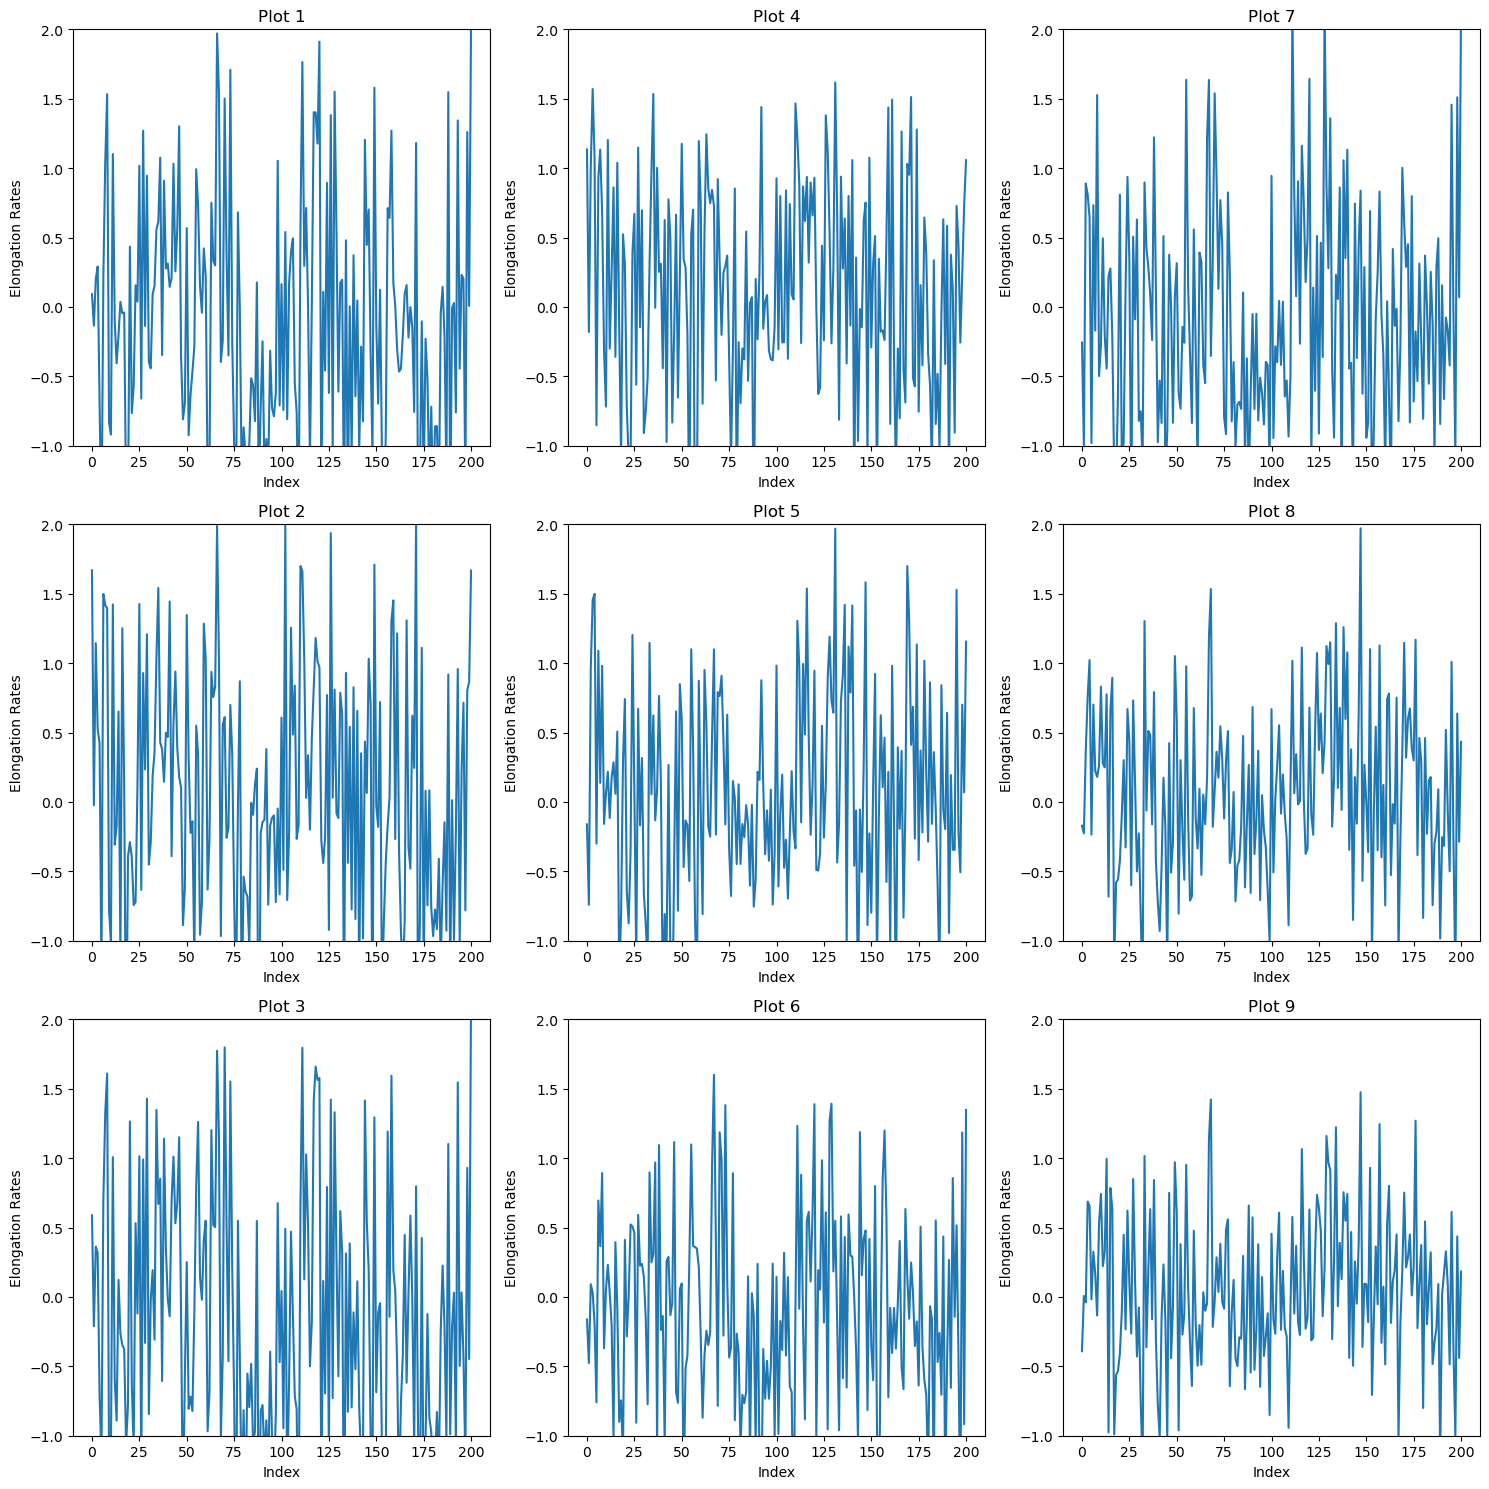

In [16]:
num_points = 2000
indices = np.arange(num_points)

# Subset the data for indices 0 to 200
subset_indices = indices[:201]  # 0 to 200
subset_outputs = outputs[:, :201]  # Select the first 201 points for all samples

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        axs[i, j].plot(subset_indices, subset_outputs[i + j * 3])
        axs[i, j].set_ylim(-1, 2)
        axs[i, j].set_xlabel('Index')
        axs[i, j].set_ylabel('Elongation Rates')
        axs[i, j].set_title(f'Plot {i + j * 3 + 1}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

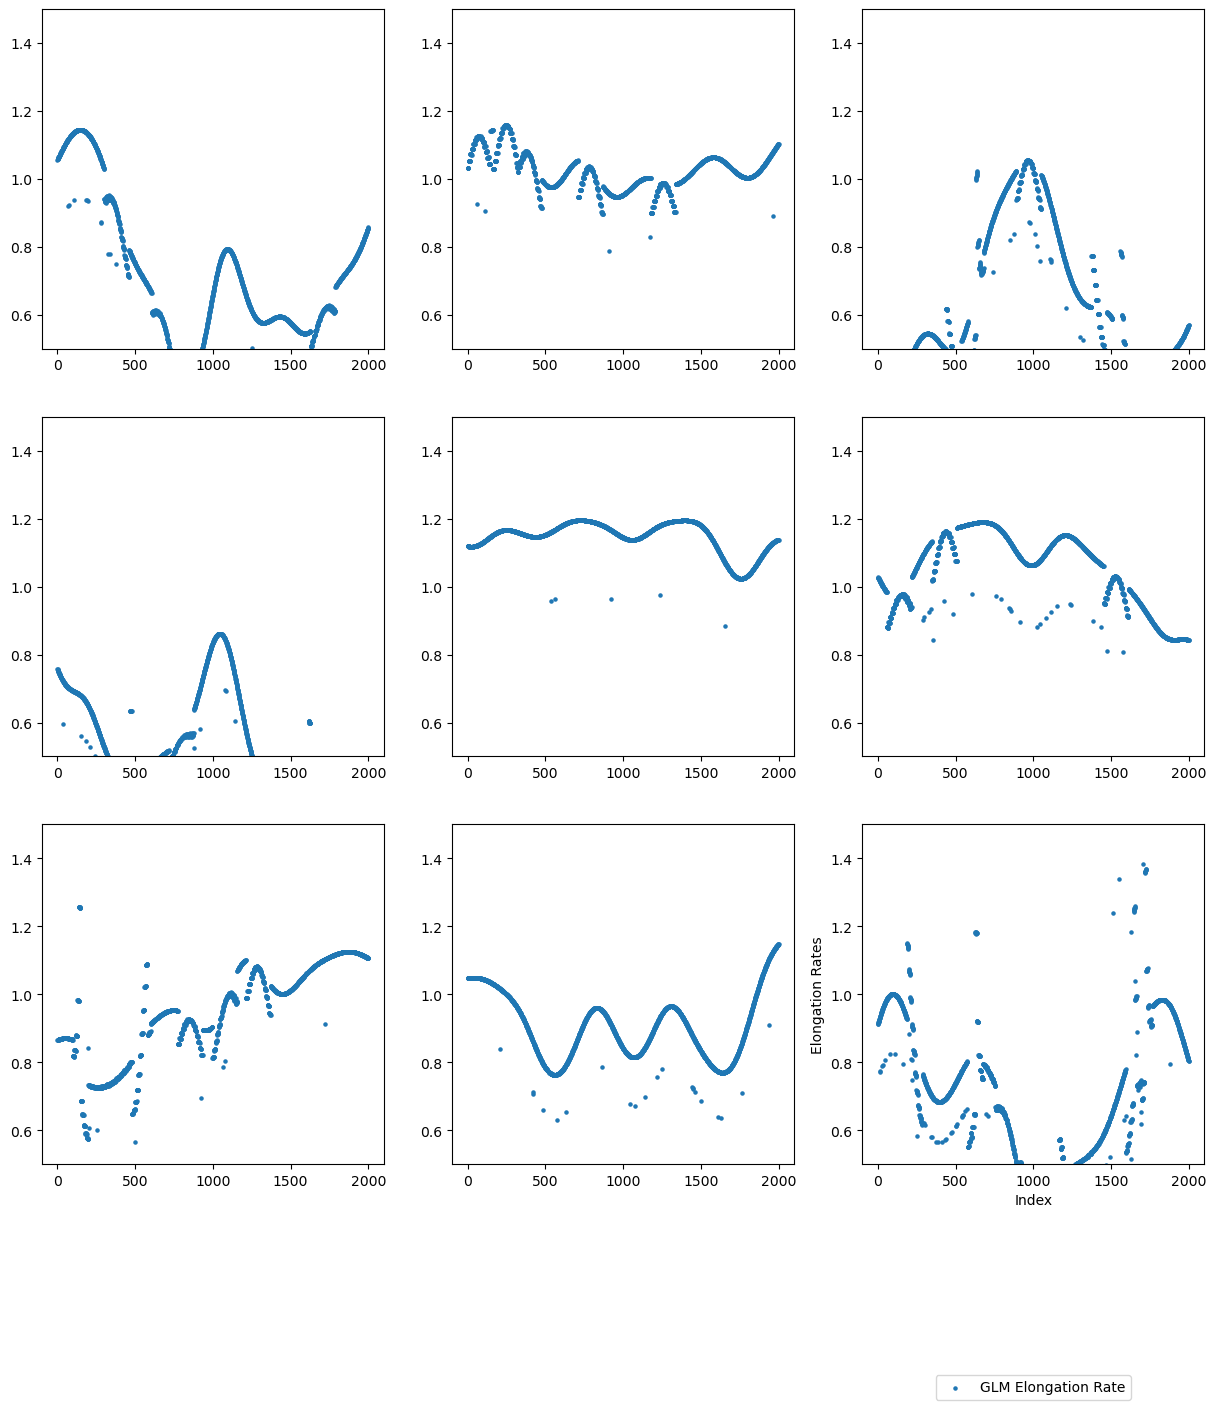

In [19]:
indices = range(len(targets[0]))

fig, axs = plt.subplots(3, 3, figsize=(15,15))
for i in range(3):
    for j in range(3):
        axs[i, j].scatter(indices, targets[i+j*3], s=5)
        axs[i, j].scatter(indices, outputs[i+j*3], s=5)
        axs[i, j].set_ylim(-1, 2)

plt.xlabel('Index')
plt.ylabel('Elongation Rates')
plt.legend(['GLM Elongation Rate', 'NN Elongation Rate'], loc='upper center', bbox_to_anchor=(0.5, -0.6))